In [1]:
import pandas as pd
import numpy as np
import socket
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from datetime import datetime
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from graphviz import Source
from IPython.display import SVG
from sklearn.svm import SVC
from sklearn import svm
import networkx as nx
import colorsys
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df = pd.read_csv('Without_Best_Features_Final_Fraud_Data.csv')
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])
df['purchase_weekday'] = df['purchase_time'].apply(lambda x: datetime.strftime(x, '%A'))
df['purchase_week'] = df['purchase_time'].apply(lambda x: x.week)
df = df.drop(['signup_time', 'purchase_time'], axis=1)
le = LabelEncoder()
df['device_id'] = le.fit_transform(df['device_id'])
df['source'] = le.fit_transform(df['source'])
df['browser'] = le.fit_transform(df['browser'])
df['sex'] = le.fit_transform(df['sex'])
df['ip_address'] = le.fit_transform(df['ip_address'])
df['country'] = le.fit_transform(df['country'])
df['purchase_weekday'] = le.fit_transform(df['purchase_weekday'])
df.head()

,user_id,purchase_value,device_id,source,browser,sex,age,country,ip_address,blacklisted,class,purchase_weekday,purchase_week
0,22058,34,89215,2,0,1,39,84,109404,0,0,2,16
1,333320,16,24078,0,0,0,53,171,62432,0,0,1,24
2,1359,15,131216,2,3,1,53,171,35637,0,1,4,1
3,150084,44,3977,2,4,1,41,172,80386,0,0,1,19
4,221365,39,68757,0,4,1,45,171,87814,0,0,6,37


### Models

In [3]:
X = df.drop('class', axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

,user_id,purchase_value,device_id,source,browser,sex,age,country,ip_address,blacklisted,class,purchase_weekday,purchase_week
0,22058,34,89215,2,0,1,39,84,109404,0,0,2,16
1,333320,16,24078,0,0,0,53,171,62432,0,0,1,24
2,1359,15,131216,2,3,1,53,171,35637,0,1,4,1
3,150084,44,3977,2,4,1,41,172,80386,0,0,1,19
4,221365,39,68757,0,4,1,45,171,87814,0,0,6,37


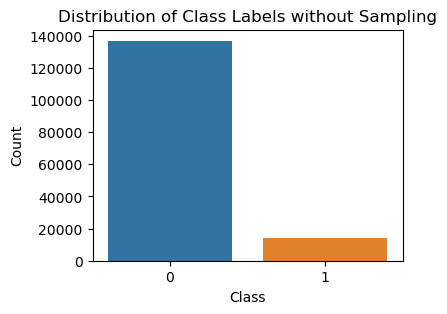

In [4]:
display(df.head())
plt.figure(figsize=(4, 3))
sns.countplot(x = "class", data=df)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Class Labels without Sampling")
plt.show()

# Decision Tree Classifier

Confusion Matrix:
[[38709  2408]
 [ 1851  2366]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     41117
           1       0.50      0.56      0.53      4217

    accuracy                           0.91     45334
   macro avg       0.72      0.75      0.74     45334
weighted avg       0.91      0.91      0.91     45334



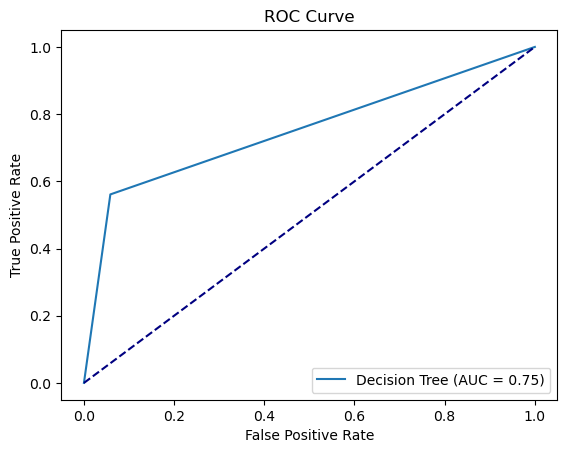

In [5]:
# Decision Tree Classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
y_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# graph = Source(tree.export_graphviz(clf, out_file=None,feature_names=feature_cols,class_names=['0', '1'], filled = True))
# display(SVG(graph.pipe(format='svg')))
# pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_})

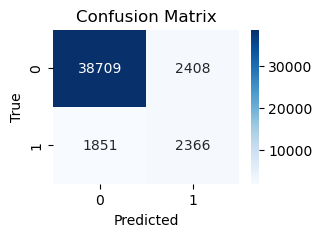

In [6]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

Best max_depth: 6
Confusion Matrix:
[[40979   138]
 [ 1925  2292]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41117
           1       0.94      0.54      0.69      4217

    accuracy                           0.95     45334
   macro avg       0.95      0.77      0.83     45334
weighted avg       0.95      0.95      0.95     45334



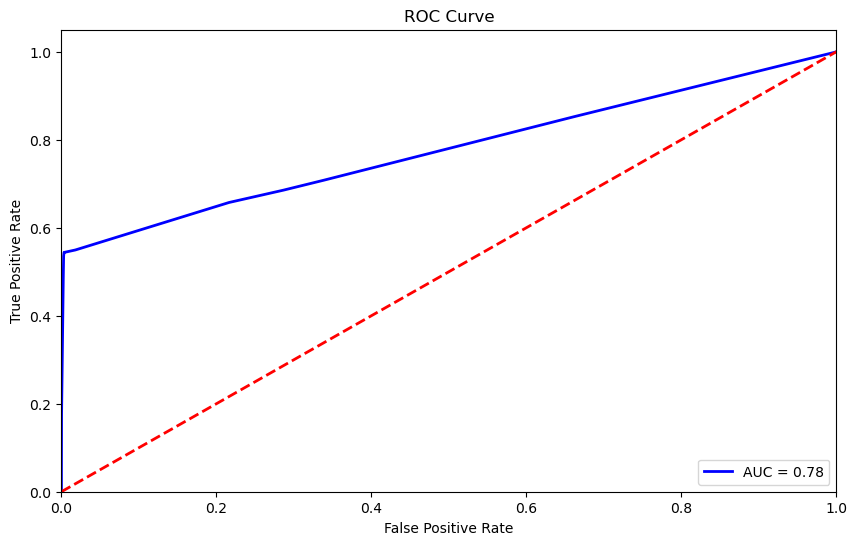

In [7]:
# Decision Tree with hyperparameters
param_grid = {'max_depth': [2, 4, 6, 8, 10, 20, 30, 50, 100]}
clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)
print("Best max_depth:", grid_search.best_params_['max_depth'])
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
y_prob = best_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

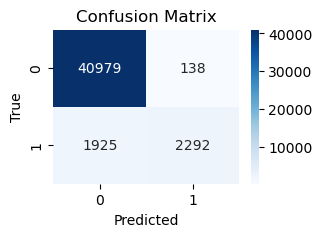

In [8]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

# MLP Classifier

In [9]:
def show_ann(mlp):
    hidden_layers_n = len(mlp.coefs_)-1
    layers_n = hidden_layers_n + 2
    input_neurons_n = len(mlp.coefs_[0])
    hidden_neurons_n = [len(mlp.coefs_[i+1]) for i in range(hidden_layers_n)]
    output_neurons_n = len(mlp.coefs_[-1][0])
    G = nx.DiGraph()
    pos = {}
    for i in range(input_neurons_n):
        pos['Layer0_{}'.format(i)] = (i,layers_n-1)
    for j in range(hidden_layers_n):
        prev_layer = j
        cur_layer = j+1
        if (j == 0):
            prev_size = input_neurons_n
        else:
            prev_size = hidden_neurons_n[j-1]
        for i in range(hidden_neurons_n[j]):
            pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
            for k in range(prev_size):
                w = mlp.coefs_[prev_layer][k][i]
                G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)
    prev_layer = hidden_layers_n
    cur_layer = hidden_layers_n+1
    for i in range(output_neurons_n):
        pos['Layer{}_{}'.format(cur_layer,i)] = (i,layers_n-1-cur_layer)
        for k in range(hidden_neurons_n[-1]):
            w = mlp.coefs_[prev_layer][k][i]
            G.add_edge('Layer{}_{}'.format(prev_layer,k),'Layer{}_{}'.format(cur_layer,i), weight=w)
    edges = G.edges()
    colors = [colorsys.hsv_to_rgb(0 if G[u][v]['weight'] < 0 else 0.65,
                                  1,#min(1, abs(G[u][v]['weight'])),
                                  1) for u,v in edges]
    weights = [abs(G[u][v]['weight'])*2 for u,v in edges]
    nx.draw(G, pos, node_color='y', node_size=450, width=weights, edge_color=colors)

Confusion Matrix:
[[41117     0]
 [ 4217     0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     41117
           1       1.00      0.00      0.00      4217

    accuracy                           0.91     45334
   macro avg       0.95      0.50      0.48     45334
weighted avg       0.92      0.91      0.86     45334



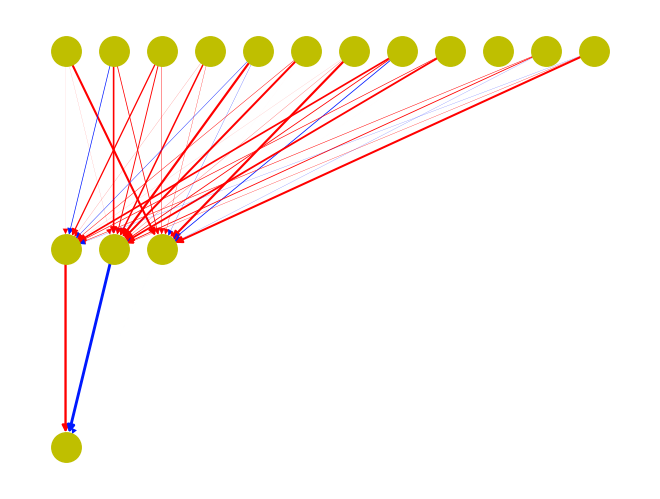

In [10]:
# Default MLP Classifier
clf = MLPClassifier(hidden_layer_sizes=(3),max_iter=5000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred, zero_division=1))
show_ann(clf)

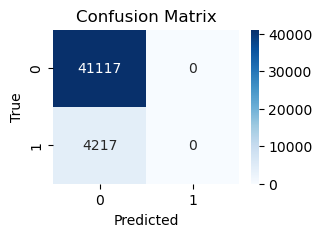

In [11]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

Confusion Matrix:
[[41117     0]
 [ 4217     0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     41117
           1       1.00      0.00      0.00      4217

    accuracy                           0.91     45334
   macro avg       0.95      0.50      0.48     45334
weighted avg       0.92      0.91      0.86     45334



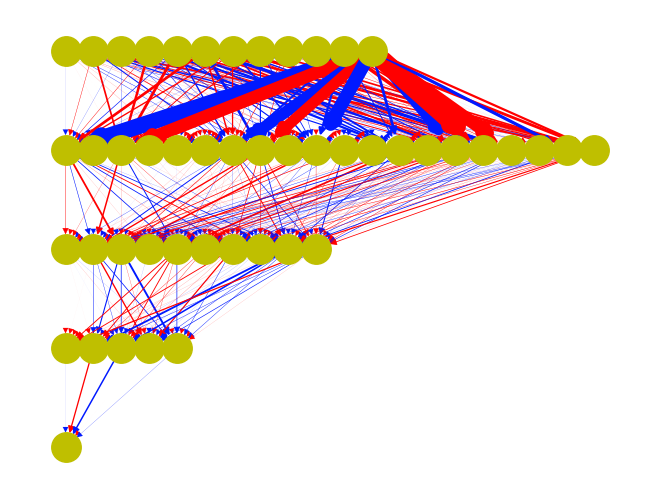

In [12]:
# Default MLP Classifier with more layers
clf = MLPClassifier(hidden_layer_sizes=(20, 10, 5),max_iter=5000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred, zero_division=1))
show_ann(clf)

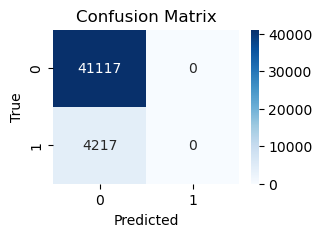

In [13]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

# K Neighbors Classifier

Confusion Matrix:
[[40753   364]
 [ 4162    55]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     41117
           1       0.13      0.01      0.02      4217

    accuracy                           0.90     45334
   macro avg       0.52      0.50      0.49     45334
weighted avg       0.84      0.90      0.86     45334

AUC-ROC score: 0.5172


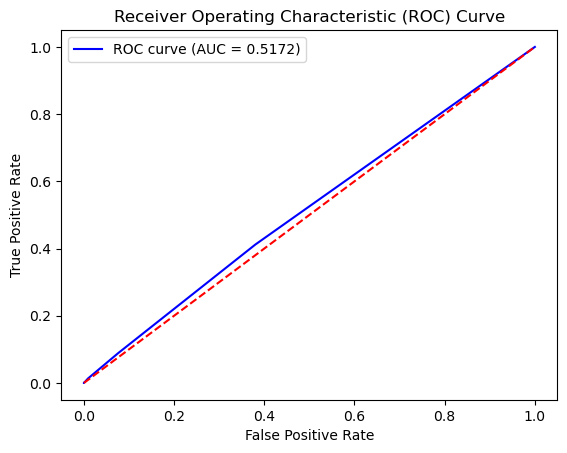

In [14]:
# K Neighbors Classifier with default classifier
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
y_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
print(f'AUC-ROC score: {auc_score:.4f}')
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

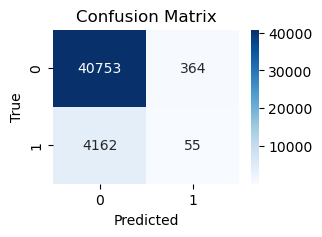

In [15]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

Best n_neighbors: 3
Confusion Matrix:
[[39967  1150]
 [ 4067   150]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     41117
           1       0.12      0.04      0.05      4217

    accuracy                           0.88     45334
   macro avg       0.51      0.50      0.50     45334
weighted avg       0.83      0.88      0.86     45334



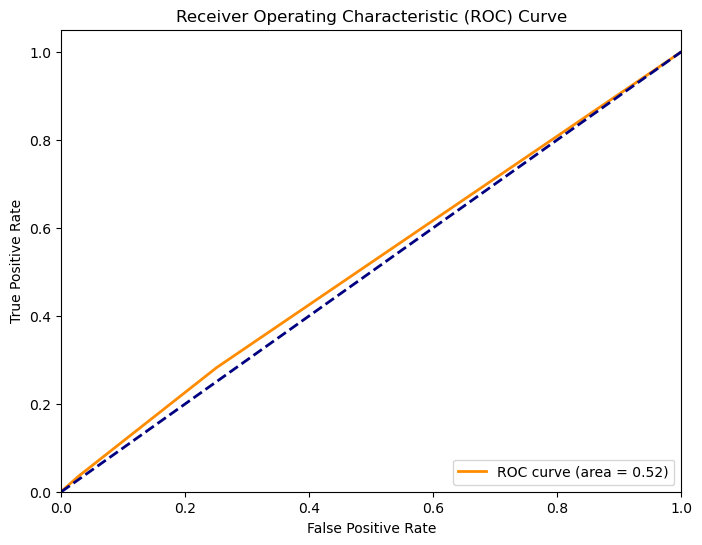

In [16]:
# K Neighbors Classifier with hyperparameters
param_grid = {'n_neighbors': [3, 5, 7, 9]}
clf = KNeighborsClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)
print("Best n_neighbors:", grid_search.best_params_['n_neighbors'])
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
y_prob = best_clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

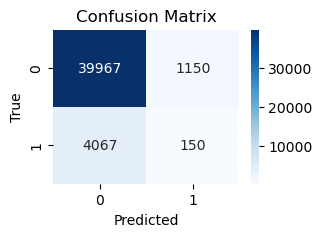

In [17]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

# Random Forest 

Confusion Matrix:
[[41002   115]
 [ 1926  2291]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41117
           1       0.95      0.54      0.69      4217

    accuracy                           0.95     45334
   macro avg       0.95      0.77      0.83     45334
weighted avg       0.95      0.95      0.95     45334



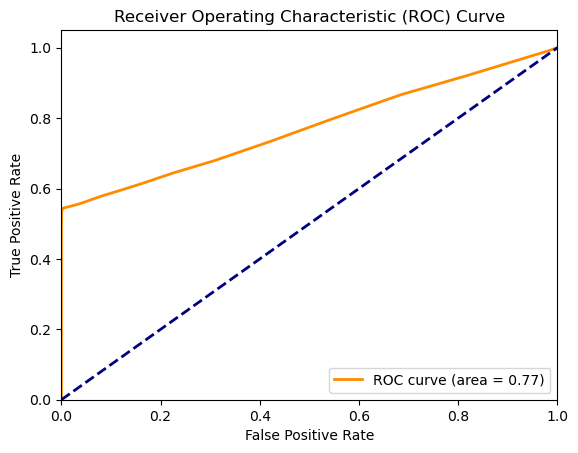

In [18]:
# Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
y_prob = rfc.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

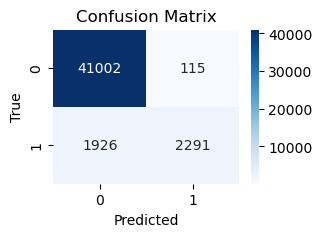

In [19]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

Best parameters: {'max_depth': 8, 'n_estimators': 100}
Confusion Matrix:
[[40967   150]
 [ 1932  2285]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41117
           1       0.94      0.54      0.69      4217

    accuracy                           0.95     45334
   macro avg       0.95      0.77      0.83     45334
weighted avg       0.95      0.95      0.95     45334

AUC-ROC score: 0.7735


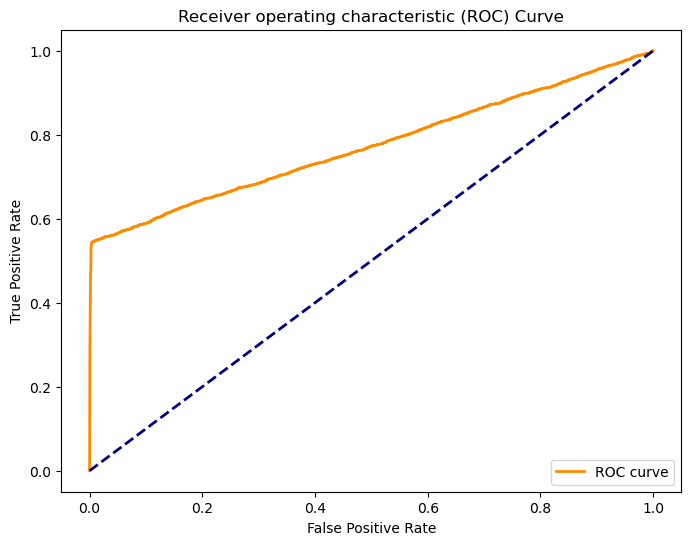

In [20]:
# Random Forest with hyperparameters
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [4, 8]}
rfc = RandomForestClassifier()
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_rfc = grid_search.best_estimator_
y_pred = best_rfc.predict(X_test)
print("Best parameters:", grid_search.best_params_)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
y_prob = best_rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
print(f'AUC-ROC score: {auc_score:.4f}')
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

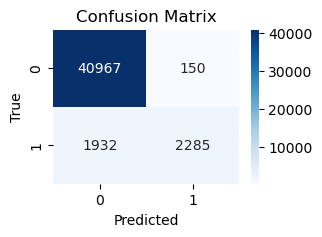

In [21]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

# Light Gradient Boosting

Confusion Matrix:
[[40990   127]
 [ 1926  2291]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41117
           1       0.95      0.54      0.69      4217

    accuracy                           0.95     45334
   macro avg       0.95      0.77      0.83     45334
weighted avg       0.95      0.95      0.95     45334

AUC-ROC score: 0.7789


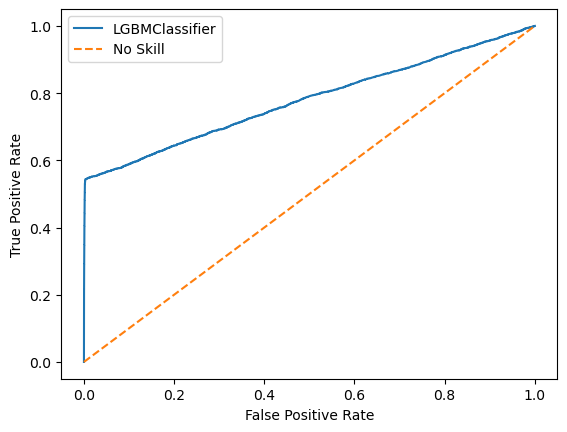

In [22]:
# Light Gradient Boosting Machine Classifier
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
y_prob = clf.predict_proba(X_test)[:,1]
auc_score = roc_auc_score(y_test, y_prob)
print(f'AUC-ROC score: {auc_score:.4f}')
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='LGBMClassifier')
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

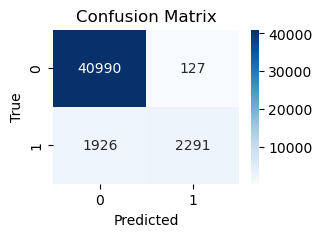

In [23]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

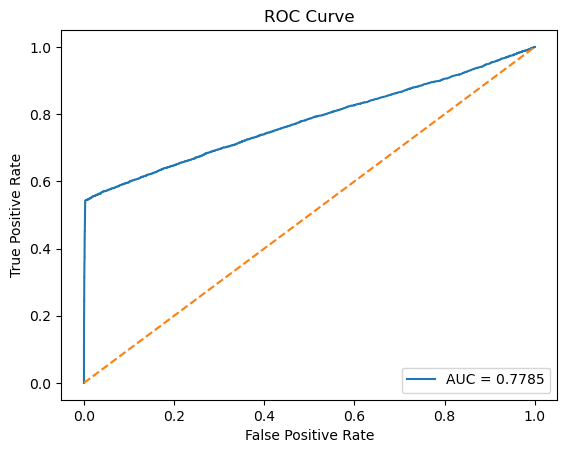

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'num_leaves': 10}
Confusion Matrix:
[[40989   128]
 [ 1926  2291]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41117
           1       0.95      0.54      0.69      4217

    accuracy                           0.95     45334
   macro avg       0.95      0.77      0.83     45334
weighted avg       0.95      0.95      0.95     45334



In [24]:
# Light Gradient Boosting Machine Classifier with hyperperameters
param_grid = {'max_depth': [3, 5, 10], 'num_leaves': [5, 10], 'learning_rate': [0.01, 0.1, 1]}
clf = lgb.LGBMClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
y_prob = best_clf.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
y_pred = best_clf.predict(X_test)
print("Best hyperparameters:", grid_search.best_params_)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

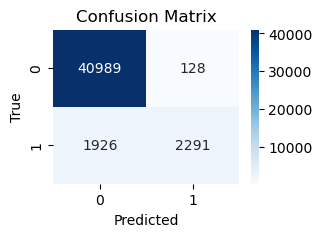

In [25]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

# AdaBoost Classifier

Confusion Matrix:
[[40875   242]
 [ 1919  2298]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     41117
           1       0.90      0.54      0.68      4217

    accuracy                           0.95     45334
   macro avg       0.93      0.77      0.83     45334
weighted avg       0.95      0.95      0.95     45334

AUC-ROC score: 0.7780


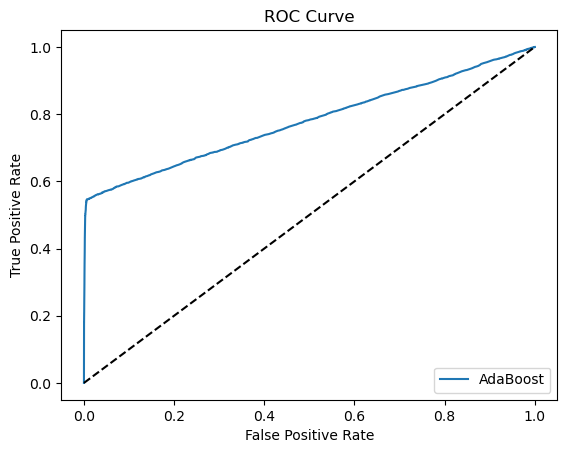

In [26]:
# AdaBoost Classifier with default classifier
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
y_prob = clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
print(f'AUC-ROC score: {auc_score:.4f}')
plt.plot(fpr, tpr, label='AdaBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

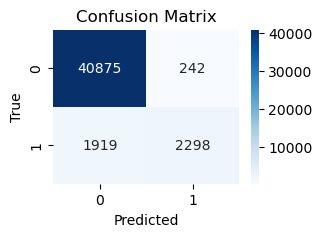

In [27]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

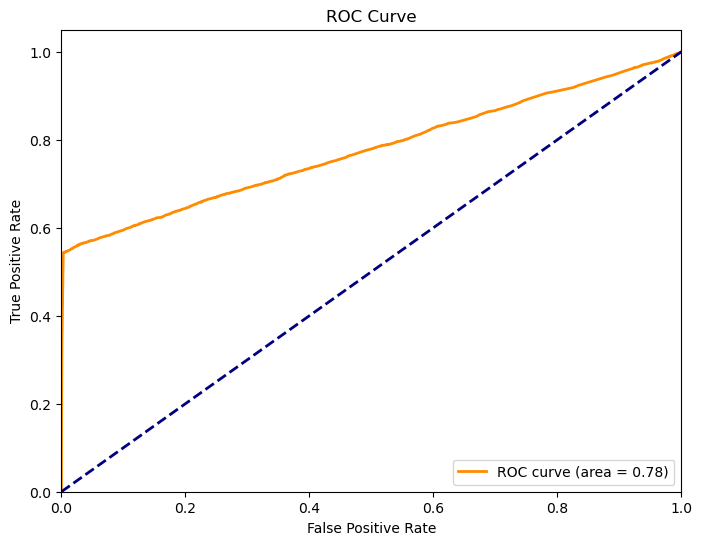

Best parameters: {'learning_rate': 0.01, 'n_estimators': 100}
Confusion Matrix:
[[40985   132]
 [ 1932  2285]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41117
           1       0.95      0.54      0.69      4217

    accuracy                           0.95     45334
   macro avg       0.95      0.77      0.83     45334
weighted avg       0.95      0.95      0.95     45334



In [28]:
# AdaBoost Classifier with hyperparameters
param_grid = {'n_estimators': [50, 100],'learning_rate': [0.01, 0.1, 1]}
clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5))
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
y_prob = best_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
y_pred = best_clf.predict(X_test)
print("Best parameters:", grid_search.best_params_)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred, zero_division=1))

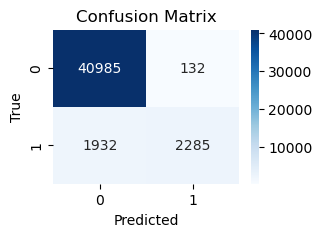

In [29]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

# Gradient Boosting Classifier

AUC-ROC score: 0.7763


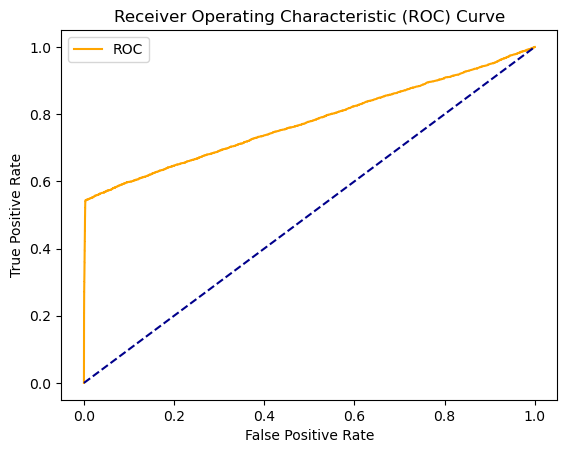

Confusion Matrix:
[[40998   119]
 [ 1955  2262]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41117
           1       0.95      0.54      0.69      4217

    accuracy                           0.95     45334
   macro avg       0.95      0.77      0.83     45334
weighted avg       0.95      0.95      0.95     45334



In [30]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print(f'AUC-ROC score: {auc_score:.4f}')
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
y_pred = clf.predict(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

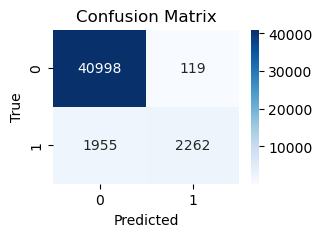

In [31]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

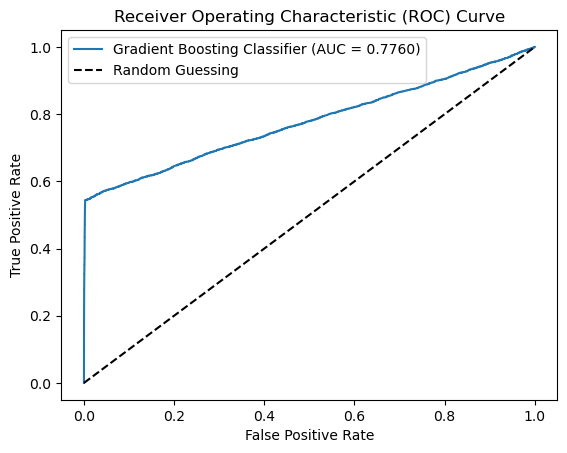

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50}
Confusion Matrix:
[[40991   126]
 [ 1926  2291]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41117
           1       0.95      0.54      0.69      4217

    accuracy                           0.95     45334
   macro avg       0.95      0.77      0.83     45334
weighted avg       0.95      0.95      0.95     45334



In [32]:
# Gradient Boosting Classifier with hyperparameters
param_grid = {'max_depth': [2, 4, 6],
              'n_estimators': [50, 100],
              'learning_rate': [0.01, 0.1, 1.0]}
clf = GradientBoostingClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)
y_prob = best_clf.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'Gradient Boosting Classifier (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
print("Best hyperparameters:", grid_search.best_params_)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

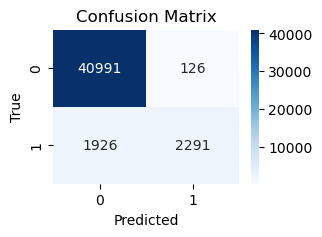

In [33]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

# Logistic Regression Classifier

Confusion Matrix:
[[41117     0]
 [ 4208     9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     41117
           1       1.00      0.00      0.00      4217

    accuracy                           0.91     45334
   macro avg       0.95      0.50      0.48     45334
weighted avg       0.92      0.91      0.86     45334



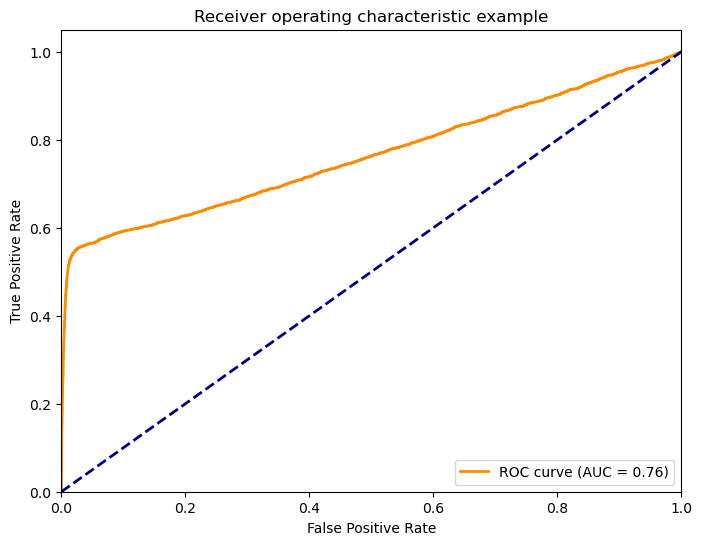

In [34]:
# Logistic Regression Classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
y_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

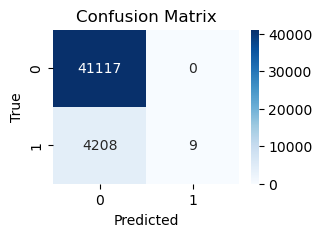

In [35]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

/Users/svinayachanta/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best hyperparameters: {'C': 100, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1'}
Confusion Matrix:
[[40869   248]
 [ 1998  2219]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     41117
           1       0.90      0.53      0.66      4217

    accuracy                           0.95     45334
   macro avg       0.93      0.76      0.82     45334
weighted avg       0.95      0.95      0.94     45334



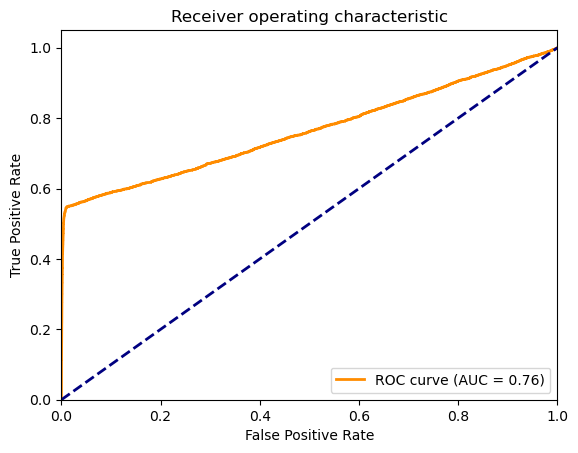

In [36]:
# Logistic Regression with hyperparameters
param_grid = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
              'class_weight': [{0:1, 1:1}, {0:2, 1:1}, {0:1, 1:2}, {0:3, 1:1}, {0:1, 1:3}, 'balanced', None]}
clf = LogisticRegression(solver='liblinear', max_iter=1000)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)
print("Best hyperparameters:", grid_search.best_params_)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
y_prob = best_clf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

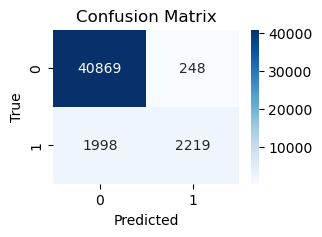

In [37]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

# XGBoost Classifier

AUC-ROC score: 0.7707


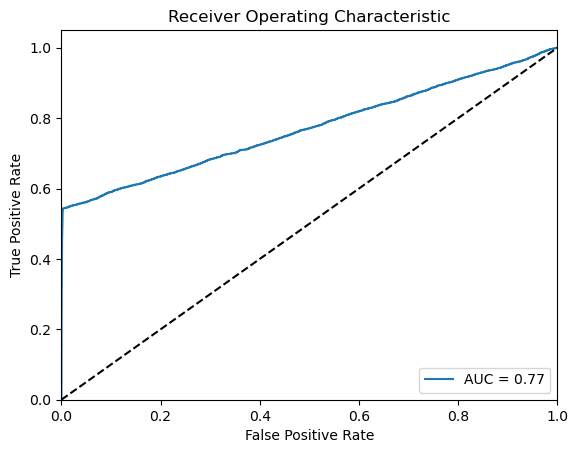

Confusion Matrix:
[[40994   123]
 [ 1925  2292]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41117
           1       0.95      0.54      0.69      4217

    accuracy                           0.95     45334
   macro avg       0.95      0.77      0.83     45334
weighted avg       0.95      0.95      0.95     45334



In [38]:
# XGBoost Classifier with default hyperparameters
clf = XGBClassifier()
clf.fit(X_train, y_train)
y_prob = clf.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print(f'AUC-ROC score: {auc_score:.4f}')
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
y_pred = clf.predict(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

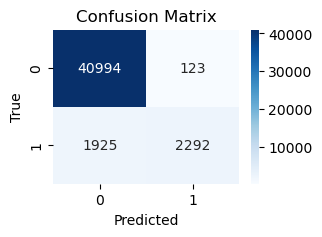

In [39]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'subsample': 0.8}
Confusion Matrix:
[[40995   122]
 [ 1933  2284]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41117
           1       0.95      0.54      0.69      4217

    accuracy                           0.95     45334
   macro avg       0.95      0.77      0.83     45334
weighted avg       0.95      0.95      0.95     45334



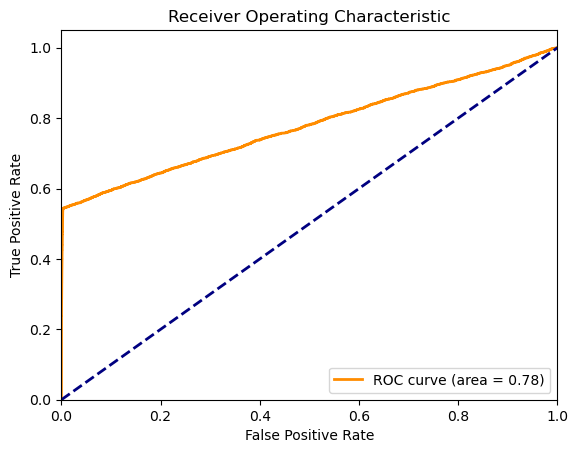

In [40]:
# XGBoost Classifier with hyperparameters
param_grid = {'learning_rate': [0.01, 0.1],'max_depth': [3, 5, 7],'subsample': [0.6, 0.8],'colsample_bytree': [0.6, 0.8]}
clf = XGBClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)
y_prob = best_clf.predict_proba(X_test)[:, 1]
print("Best hyperparameters:", grid_search.best_params_)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

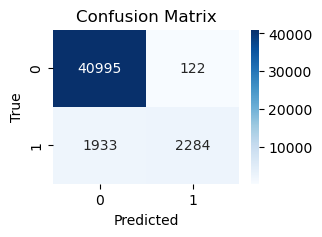

In [41]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

# Extra Trees Classifier 

Confusion Matrix:
[[41042    75]
 [ 1926  2291]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41117
           1       0.97      0.54      0.70      4217

    accuracy                           0.96     45334
   macro avg       0.96      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



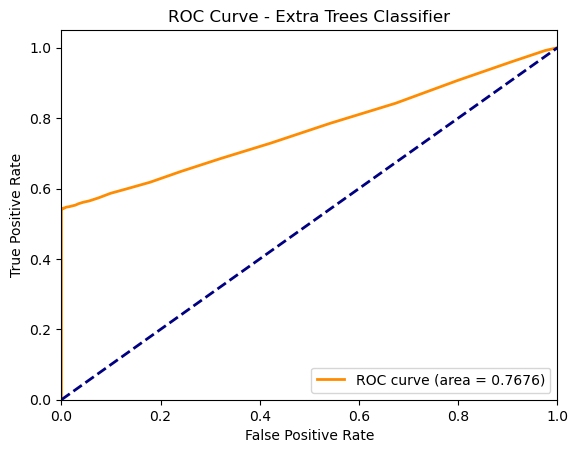

In [42]:
# Extra Trees Classifier 
etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
y_prob = etc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Extra Trees Classifier')
plt.legend(loc="lower right")
plt.show()

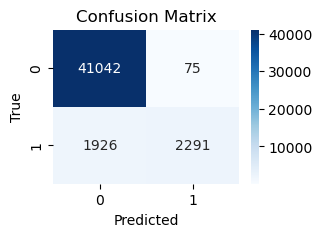

In [43]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()

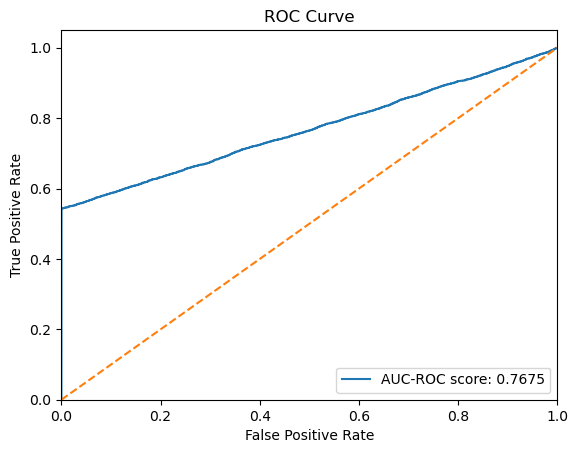

Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Confusion Matrix:
[[41047    70]
 [ 1926  2291]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41117
           1       0.97      0.54      0.70      4217

    accuracy                           0.96     45334
   macro avg       0.96      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



In [44]:
# Extra Trees Classifier with hyperperameters
param_grid = {'n_estimators': [50, 100],'max_depth': [10, 20],'min_samples_split': [2, 5],'min_samples_leaf': [1, 2]}
etc = ExtraTreesClassifier()
grid_search = GridSearchCV(etc, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
best_etc = grid_search.best_estimator_
y_pred = best_etc.predict(X_test)
y_prob = best_etc.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC-ROC score: {auc_score:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
print("Best hyperparameters:", grid_search.best_params_)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))

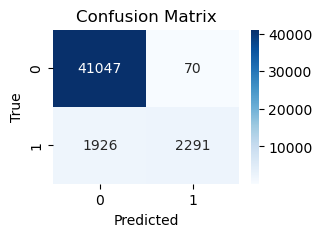

In [45]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()